# Objectives
For questions 1,2,3 and 4 use the train.csv dataset. For question 5 you should use the dataset 'train.csv' and 'test_X.csv'.

    1.    What are the 3 countries where most orders are placed?
    2.    What are the hours when most orders are placed in Spain?
    3.    What is the average price per order in the store with ID 12513?
    4.    Taking into account the peaks of demand in Spain, if the delivery drivers work in 8-hour shifts.
        Shift 1 (00:00-08:00)
        Shift 2 (08:00-16:00)
        Shift 3 (16:00-00:00)

        What percentage of delivery drivers would you allocate for each shift to cope with peak demand (e.g. Shift 1 30%, Shift 2 10% and Shift 3 60%)?

    5.    Perform a predictive machine learning model of the 'train.csv' dataset using the predictor variables delivered in the 'test_X' dataset that will predict whether the order will be cancelled or not ('final_status' column).

For simplicity, you can assign the 'CanceledStatus' values to 0 and the 'DeliveredStatus' values to 1.

0 = CanceledStatus
1 = DeliveredStatus

Deliver the predictions in a separate csv. As can be seen in the 'example_predictions' example. The quality of the prediction will be measured by the f1-score(macro)

In [1]:
# Importing libraries for:
# Data processing
# -----------------------------------------------------------------------
import numpy as np
import pandas as pd

# Plots
# ------------------------------------------------------------------------
import matplotlib.pyplot as plt
import seaborn as sns
plt.rcParams["figure.figsize"] = (25,16) 

# Stats
# ------------------------------------------------------------------------
import sidetable

# Times and dates
# ------------------------------------------------------------------------
import datetime as dt
from datetime import datetime

In [2]:
# Loading a dataframe
df = pd.read_csv('data/train.csv')
df.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,33446280,14:11:09,AR,55379,PAID,2,11.88,DeliveredStatus
1,33107339,11:47:41,GT,23487,PAID,2,5.20,DeliveredStatus
2,32960645,11:53:53,CR,62229,PAID,1,6.03,DeliveredStatus
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
4,32157739,21:32:16,AR,13917,PAID,1,5.36,CanceledStatus


In [4]:
# Checking shape, info and main statistical attributes
df.shape

(54330, 8)

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54330 entries, 0 to 54329
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   order_id        54330 non-null  int64  
 1   local_time      54330 non-null  object 
 2   country_code    54330 non-null  object 
 3   store_address   54330 non-null  int64  
 4   payment_status  54330 non-null  object 
 5   n_of_products   54330 non-null  int64  
 6   products_total  54330 non-null  float64
 7   final_status    54330 non-null  object 
dtypes: float64(1), int64(3), object(4)
memory usage: 3.3+ MB


In [4]:
# For numeric variables
df.describe().T

,count,mean,std,min,25%,50%,75%,max
order_id,54330.0,3.278267e+07,445940.244923,31503775.0,32400066.75,32781587.50,33183798.00,33560846.00
store_address,54330.0,4.160938e+04,21903.267141,190.0,21369.00,45993.50,62004.00,75236.00
n_of_products,54330.0,2.815792e+00,2.430936,1.0,1.00,2.00,3.00,39.00
products_total,54330.0,9.838136e+00,9.260352,0.0,4.13,7.13,12.77,221.48


> * We can conclude that order_id and store_address are in fact categorical variables.
> * Normally people buy 2 products per order, although there is a maximum of 39 (check outliers)
> * There is a minimum order total cost of 0€ (check how often this happens) although the most usual total cost is of around 7€


In [5]:
# For categorical variables
df.describe(include='O').T

,count,unique,top,freq
local_time,54330,32905,09:03:01,38
country_code,54330,23,AR,11854
payment_status,54330,3,PAID,53854
final_status,54330,2,DeliveredStatus,48498


> * The most common order time is exactly 9:03:01
> * The most frequent country in this dataset is Argentina
> * Only `10.73%` of orders have a Cancelled Status --> (5832 out of 54330)

In [6]:
# Checking nulls
df.isnull().sum()

order_id          0
local_time        0
country_code      0
store_address     0
payment_status    0
n_of_products     0
products_total    0
final_status      0
dtype: int64

#  1.    What are the 3 countries where most orders are placed?
_¿Cuáles son los 3 paises en los que más pedidos se realizan?_

In [9]:
df['country_code'].value_counts().head(3)

AR    11854
ES    11554
TR     5696
Name: country_code, dtype: int64

> ##### Argentina (AR), Spain (ES) and Turkey (TR) are the three countries where most orders are placed.
>
> ##### _Argentina (AR), España (ES) y Turquía (TR) son los tres países donde se realizan más pedidos._

# 2.    What are the hours when most orders are placed in Spain?
_¿Cuáles son las horas en las que se realizan más pedidos en España?_

In [7]:
# First let's make a subset filtered by Spain
spain = df[df['country_code']== 'ES']
spain.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
8,32236610,17:09:16,ES,30120,PAID,3,4.35,DeliveredStatus
13,32235607,18:02:18,ES,18682,PAID,9,16.12,DeliveredStatus
19,32670668,14:37:58,ES,8994,PAID,12,17.93,DeliveredStatus
24,32126718,21:12:30,ES,14872,PAID,3,22.00,DeliveredStatus


In [8]:
# Transforming the column dtype to datetime in hour granularity
spain.local_time = spain.local_time.astype("datetime64").dt.hour
spain.head()

/tmp/ipykernel_1205/3133250858.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  spain.local_time = spain.local_time.astype("datetime64").dt.hour


,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
3,32089564,20,ES,29446,PAID,6,6.37,DeliveredStatus
8,32236610,17,ES,30120,PAID,3,4.35,DeliveredStatus
13,32235607,18,ES,18682,PAID,9,16.12,DeliveredStatus
19,32670668,14,ES,8994,PAID,12,17.93,DeliveredStatus
24,32126718,21,ES,14872,PAID,3,22.00,DeliveredStatus


In [10]:
# Show the value counts for each hour
pd.options.display.max_rows=None
spain['local_time'].value_counts().head(10)

20    1716
21    1155
19    1128
13    1047
14     956
18     821
15     696
17     680
22     665
16     618
Name: local_time, dtype: int64

In [12]:
# In a dataframe:
spaingr = spain.groupby(['local_time']).count().sort_values(by = 'order_id', ascending=False).reset_index()
spaingr.head()

,local_time,order_id,country_code,store_address,payment_status,n_of_products,products_total,final_status
0,20,1716,1716,1716,1716,1716,1716,1716
1,21,1155,1155,1155,1155,1155,1155,1155
2,19,1128,1128,1128,1128,1128,1128,1128
3,13,1047,1047,1047,1047,1047,1047,1047
4,14,956,956,956,956,956,956,956


> The most common hours for ordering products in Spain seem to be from 8 to 9 PM, closely followed by 7 PM and 1 PM. However, plotting this column will give us a more accurate idea
>
> _Las horas más comunes para pedir productos en España parecen ser entre las 8 y las 9 PM, seguidas de las 7 PM y la 1 PM. Sin embargo, el trazado de esta columna nos dará una idea más precisa_

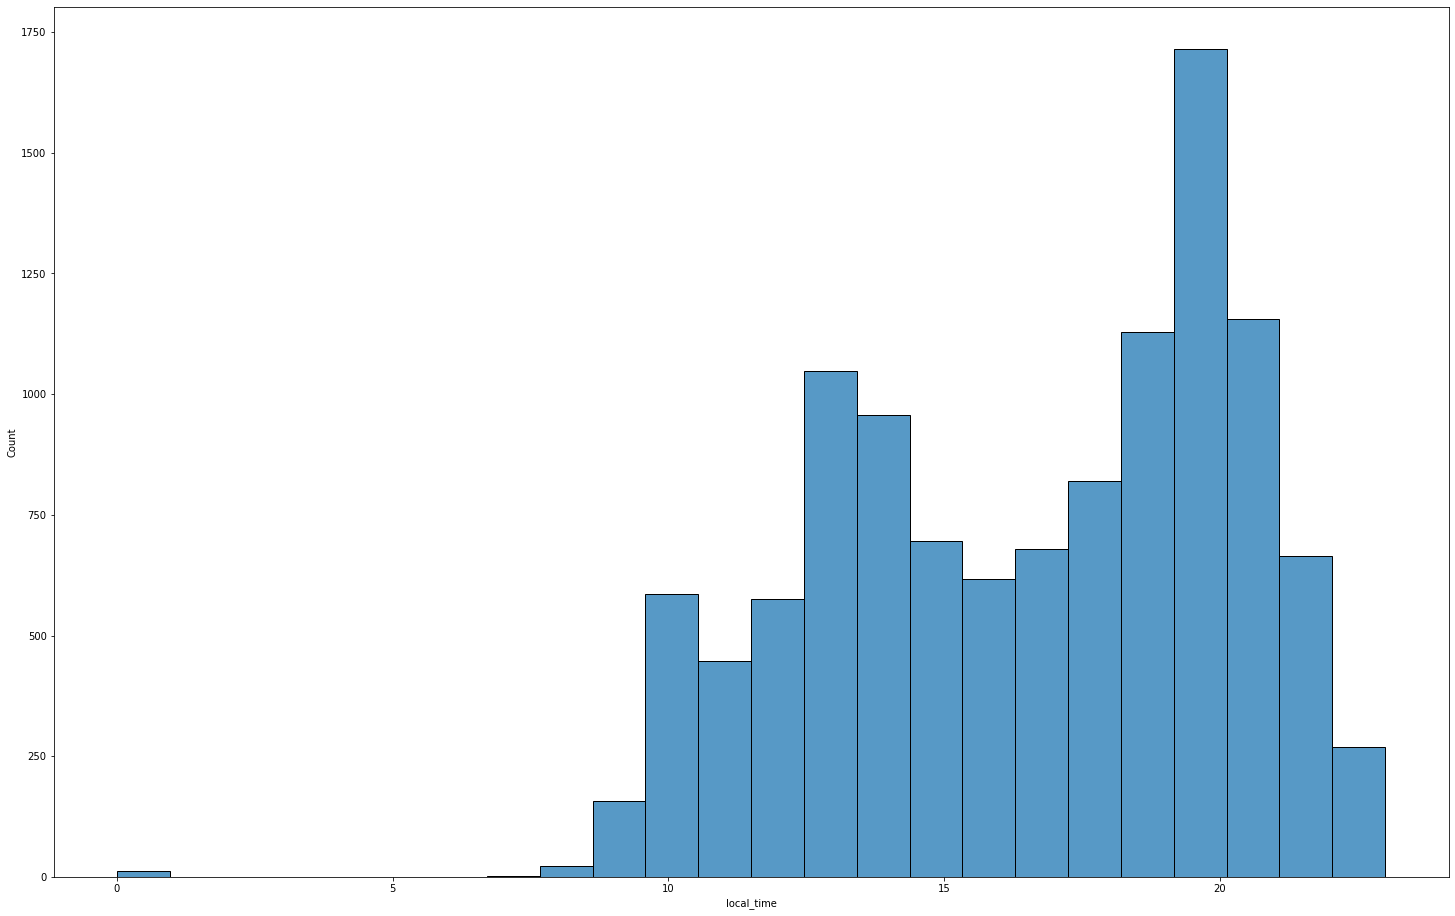

In [15]:
# Plotting the frequency of orders per hour
sns.histplot(x='local_time', data=spain, bins=24);
plt.show()

> * ##### We can confirm that the main peak happens from 7 to 9 PM, with a maximum peak at atound 8 PM.
> * ##### The most active time slots are middays and evenings.
> * ##### _Podemos confirmar que el pico principal se producen desde las 7 a las 9 PM, siendo el pico máximo en torno a las 8 PM._
> * ##### _Las franjas horarias más activas son los mediodías y las noches._

# 3.    What is the average price per order in the store with ID 12513?
_¿Cuál es el precio medio por pedido en la tienda con ID 12513?_

In [58]:
# Let's filter and calculate
df[df['store_address'] == 12513]['products_total'].mean()

17.392244897959173

> ##### The average price per order in the store with ID 12513 is of *`€17.4`*
>
> ##### _El precio medio por pedido en la tienda con ID 12513 es de *`17,4`*._

# 4. What percentage of delivery drivers would you allocate for each shift to cope with peak demand (e.g. Shift 1 30%, Shift 2 10% and Shift 3 60%)?
##### Taking into account the peaks of demand in Spain, if the delivery drivers work in 8-hour shifts.

        Shift 1 (00:00-08:00)

        Shift 2 (08:00-16:00)
        
        Shift 3 (16:00-00:00)
        
_¿Qué porcentaje de repartidores pondrías por cada turno para que sean capaces de hacer frente a los picos de demanda? (ej: Turno 1 el 30%, Turno 2 el 10% y Turno 3 el 60%)._

> I would answer this question by analyzing the percentage of orders that take place during these time shifts
>
> _Respondería a esta pregunta analizando el porcentaje de pedidos que tienen lugar durante estos turnos_

In [14]:
# Filtering a subset by time shift 1
shift1 = spain[(spain['local_time'] >= '00:00:00') & (spain['local_time'] <= '08:00:00')]
shift1.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
3655,32756826,00:39:03,ES,16337,PAID,4,18.95,DeliveredStatus
4252,32320402,00:46:48,ES,16347,PAID,6,17.40,DeliveredStatus
6052,32497368,00:26:08,ES,16348,NOT_PAID,5,6.45,DeliveredStatus
7365,32147971,00:26:47,ES,16348,PAID,3,4.40,DeliveredStatus
7858,32499362,00:42:33,ES,16347,PAID,1,2.95,CanceledStatus


In [15]:
# Filtering a subset by time shift 2
shift2 = spain[(spain['local_time'] > '08:00:00') & (spain['local_time'] <= '16:00:00')]
shift2.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
19,32670668,14:37:58,ES,8994,PAID,12,17.93,DeliveredStatus
75,32039883,15:29:14,ES,13660,PAID,6,45.90,DeliveredStatus
78,32528876,10:40:44,ES,7777,PAID,3,13.65,DeliveredStatus
102,32796628,14:06:42,ES,16245,PAID,21,33.33,CanceledStatus
121,33068237,13:27:31,ES,29451,PAID,3,21.40,DeliveredStatus


In [16]:
# Filtering a subset by time shift 3
shift3 = spain[(spain['local_time'] > '16:00:00') & (spain['local_time'] <= '23:59:59')]
shift3.head()

,order_id,local_time,country_code,store_address,payment_status,n_of_products,products_total,final_status
3,32089564,20:15:21,ES,29446,PAID,6,6.37,DeliveredStatus
8,32236610,17:09:16,ES,30120,PAID,3,4.35,DeliveredStatus
13,32235607,18:02:18,ES,18682,PAID,9,16.12,DeliveredStatus
24,32126718,21:12:30,ES,14872,PAID,3,22.00,DeliveredStatus
25,32229263,16:13:48,ES,14872,PAID,1,15.00,DeliveredStatus


In [17]:
# Let's check the total of orders in Spain
print('Total orders in Spain are: ', spain.shape[0])

Total orders in Spain are:  11554


In [18]:
# Let's check if the sum of orders per shift coincides with the total
print('The sum of the number of orders per shift is:', shift1.shape[0] + shift2.shape[0] + shift3.shape[0])

The sum of the number of orders per shift is: 11554


In [19]:
# The percentage of orders according to each shift:

print('During shift 1:', round((shift1.shape[0]/spain.shape[0])*100, 2), '% of the orders take place')

During shift 1: 0.12 % of the orders take place


In [20]:
print('During shift 2:', round((shift2.shape[0]/spain.shape[0])*100, 2), '% of the orders take place')

During shift 2: 38.84 % of the orders take place


In [21]:
print('During shift 3:', round((shift3.shape[0]/spain.shape[0])*100, 2), '% of the orders take place')

During shift 3: 61.04 % of the orders take place


> ##### I would allocate:
> * ##### `0.12%` of the riders during the first shift
> * ##### `38.84%` of the riders during the second shift
> * ##### `61.04%` of the riders during the third shift
> 
> ##### _Distribuiría:_
> * ##### _El `0.12%` de los repartidores durante el primer turno_
> * ##### _El `38.84%` de los repartidores durante el segundo turno_
> * ##### _El `61.04%` de los repartidores durante el tercer turno_

Outliers and other plots will be done in the 'outliers-and-distributions' notebook

_La revisión de outliers y otras gráficas las haré en el jupyter de 'outliers-and-distributions'_